In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.model_selection import StratifiedKFold

# Part1. model building and training

In [ ]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [ ]:
# relevant file path
PROJECT_FOLDER = '/content/gdrive/MyDrive/PythonWork_Learning/Lazy_programmer/Deep-Learning-in-Python/'
CORPUS = os.path.join(PROJECT_FOLDER, 'large_files', 'translation', 'spa.txt')
GLOVE_FILE = os.path.join(PROJECT_FOLDER, 'large_files', 'glove.6B', f'glove.6B.{EMBEDDING_DIM}d.txt')
PROJECT_PATH = os.path.join(PROJECT_FOLDER, 'nlp_class3')

## prepare data
- load txt file
- tokenize
  - decide the max_length_sequenct (T)
- padding

In [ ]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# load in the data
t = 0
with open(CORPUS) as f:
  for line in f:
    # only keep a limited number of samples
    t+=1
    if t > NUM_SAMPLES:
      break

    if '\t' not in line:
      continue

    # split up the input and translation
    input_text, translation, _ = line.rstrip().split('\t')   # 這裡都有保留語句最後的標點符號，最後一個單字會與標點符號一起被加入token的計算，是否該移除??
    
    # make the target input and output
    # recall we'll be using teacher forcing
    target_text = translation + " <eos>"
    target_text_input = "<sos> " + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [ ]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts) # output is a list(which contain lists)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
print('max_len_input: ', max_len_input)

Found 2315 unique input tokens.
max_len_input:  5


In [ ]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='') # filters='' 的原因是，若不這樣做，這支程式預設會過濾掉許多特殊符號，那 < > 就會被過濾掉了
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print('max_len_target: ',max_len_target)

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1  
        # ＋1 是為了把 index=0(padding) 計算進去，之後製作decoder_targets_one_hot 會用到

Found 6358 unique output tokens.
max_len_target:  16


In [ ]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input) # output type is np.array
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs.shape:", decoder_inputs.shape)
print("decoder_inputs[0]:", decoder_inputs[0])

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 13]
decoder_inputs.shape: (10000, 16)
decoder_inputs[0]: [   2 1445    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

## Build the model

### prepare embedding layer

In [ ]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(GLOVE_FILE) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

### build the model

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_len_input, ), name='encoder_inputs')
x = embedding_layer(encoder_inputs_placeholder)

encoder_lstm = LSTM(
    LATENT_DIM, 
    return_state = True, 
    dropout=0.5  # dropout not available on gpu
)
encoder_outputs, h, c = encoder_lstm(x)
# encoder_gru = GRU(
#     LATENT_DIM, 
#     return_state = True, 
#     dropout=0.5
# )
# encoder_outputs, h = encoder_gru(x)

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [h] # for gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target, ), name='decoder_inputs')

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states) # 訓練期間輸出的 h, c 都不需要，但在預測時期就需要了

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 5)]          0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 16)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 100)       231600      encoder_inputs[0][0]             
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 16, 256)      1627904     decoder_inputs[0][0]             
____________________________________________________________________________________________

In [ ]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])


In [ ]:
# model.compile(
#   optimizer='rmsprop',
#   loss='categorical_crossentropy',
#   metrics=['accuracy']
# )
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

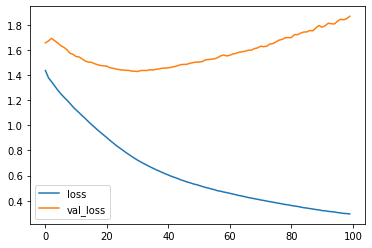

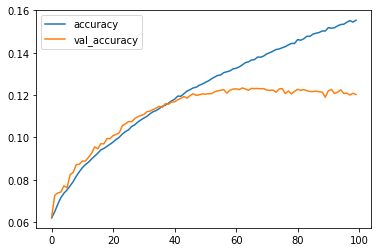

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


In [ ]:
# Save model
model.save('s2s.h5')

### use tf.data.Dataset to encapsulate raw data

In [ ]:
indices = list(range(NUM_SAMPLES))
train_idx = random.sample(indices, math.ceil(NUM_SAMPLES*0.8))
val_idx = [idx for idx in indices if idx not in train_idx]

encoder_inputs_train = encoder_inputs[train_idx]
encoder_inputs_val = encoder_inputs[val_idx]
decoder_inputs_train = decoder_inputs[train_idx]
decoder_inputs_val = decoder_inputs[val_idx]
decoder_targets_train = decoder_targets[train_idx]
decoder_targets_val = decoder_targets[val_idx]

In [ ]:
def get_training_dataset():
  def generator():
    for encoder_input, decoder_input, decoder_target in zip(encoder_inputs_train, decoder_inputs_train, decoder_targets_train):
      yield {"encoder_inputs": encoder_input,'decoder_inputs': decoder_input,}, decoder_target

  dataset = tf.data.Dataset.from_generator(
      generator, 
      output_types=({"encoder_inputs": tf.int32,
                     "decoder_inputs": tf.int32}, 
                    tf.int32)
  )
  return dataset.repeat().batch(BATCH_SIZE)


def get_val_dataset():
  def generator():
    for encoder_input, decoder_input, decoder_target in zip(encoder_inputs_val, decoder_inputs_val, decoder_targets_val):
      yield {"encoder_inputs": encoder_input,'decoder_inputs': decoder_input,}, decoder_target

  dataset = tf.data.Dataset.from_generator(
      generator, 
      output_types=({"encoder_inputs": tf.int32,
                     "decoder_inputs": tf.int32}, 
                    tf.int32)
  )
  return dataset.batch(BATCH_SIZE)

In [ ]:
next(iter(get_training_dataset()))

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=Adam(lr=0.01),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
callbacks = [
  tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(PROJECT_PATH, 's2s.h5'), 
      save_weights_only=True,
      monitor='loss', 
  )
]

In [ ]:
%%time
r = model.fit(
    get_training_dataset(), 
    validation_data=get_val_dataset(),
    epochs=EPOCHS,
    steps_per_epoch = math.ceil(len(train_idx) / BATCH_SIZE),
    callbacks=callbacks
)

In [ ]:
r.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

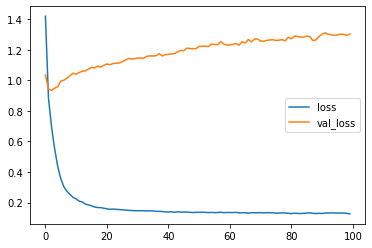

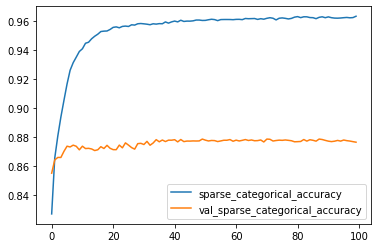

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(r.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.legend()
plt.show()

In [ ]:
model.load_weights(os.path.join(PROJECT_PATH, 's2s.h5'))

# 這邊把之前訓練好的權重，載入前面訓練用的模型架構中
# 接著會擷取前面的幾個layer(包含訓練好的權重)，重新組裝另一個預測用的模型中

# Part2 Make predictions

In [ ]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone(encoder 獨立分割出來)
# From this we will get our initial decoder hidden state

# 在訓練階段，encoder and decoder 串再一起，視為同一個模型
# 在預測階段，encoder 、decoder 則拆開來，各別建兩個模型，是因為我們需要取用encoder 輸出的 hidden state, 並且在decoder 中以文字生成模型的方式，重複使用


# ============== build encoder model ==============
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

# ============== build decoder model ==============
decoder_state_input_h = Input(shape=(LATENT_DIM, ))
decoder_state_input_c = Input(shape=(LATENT_DIM, ))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1, ))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
    decoder_inputs_single_x, 
    initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru

decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs, 
    [decoder_outputs] + decoder_states
)

In [ ]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    # print("output_tokens.shape:", output_tokens.shape, output_tokens[0,0])
    idx = np.argmax(output_tokens[0, 0])  # 這裡就不像之前文字生成模型用機率採樣，這裡用 greedy search

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]  # 目的是要從encoder_inputs隨機挑一個樣本去測試，然而[i:i+1]這個寫法，會讓輸出的樣本被包在list裡面(剛好符合模型的輸入格式要求)，是個小技巧
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I can't say.
Translation: yo no puedo decir.
Continue? [Y/n]Y
-
Input: I have a plan.
Translation: yo tengo un plan.
Continue? [Y/n]Y
-
Input: Those are nice.
Translation: ésos son cucos.
Continue? [Y/n]Y
-
Input: This is his.
Translation: ésta es suya.
Continue? [Y/n]Y
-
Input: My dog is big.
Translation: mi perro es grande.
Continue? [Y/n]Y
-
Input: Be fair.
Translation: sé justo.
Continue? [Y/n]Y
-
Input: Tom is bad.
Translation: tom es malo.
Continue? [Y/n]Y
-
Input: Stay still.
Translation: no te muevas.
Continue? [Y/n]
-
Input: Come downstairs.
Translation: bajen.
Continue? [Y/n]
-
Input: Make a list.
Translation: hagan una lista.
Continue? [Y/n]Y
-
Input: Stop screaming.
Translation: deja de chillar.
Continue? [Y/n]Y
-
Input: Come in.
Translation: entre.
Continue? [Y/n]Y
-
Input: I've seen them.
Translation: los vi.
Continue? [Y/n]N
